# Topographies

In this notebook we examine the spatial distribution of spectral features and ratio measures.

We do so by plotting topographies, and comparing spatial topographies of ratio measures to other spectral features.

In [1]:
%matplotlib inline

import csv

import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from matplotlib import cm

import mne

import seaborn as sns
sns.set_context('talk')

In [2]:
# Import custom project code
import sys
sys.path.append('../bratios')
from plot import plot_param_topo
from paths import DATA_PATHS as dp
from paths import FIGS_PATHS as fp

In [3]:
# This turns off a deprecation warning that comes up
#   It's from MNE about how we access the montage. 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Settings
SAVE_FIG = False

### Data Setup

In [5]:
# Data settings
NUM_CHAN = 111
S_RATE = 500

In [6]:
# Load data
df = pd.read_csv(dp.make_file_path(dp.eeg_outputs, 'spectral_measures_dataframe', 'csv'))

In [7]:
# Read in list of channel names that are kept in reduced 111 montage
with open(dp.make_file_path(dp.eeg_meta, 'chans111', 'csv'), 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]
    
# Read montage, reduced to 111 channel selection
montage = mne.channels.read_montage('GSN-HydroCel-129', ch_names=ch_labels)

# Create the info structure needed by MNE
info = mne.create_info(ch_labels, S_RATE, 'eeg', montage)

# Create the MNE Raw data object
raw = mne.io.RawArray(np.zeros([NUM_CHAN, 1]), info, verbose=False)

### Calculate per channel averages

In the data we have loaded, we have values for ratios and spectral parameters per subject per channel.

To get group average topographies, we will average each measure of interest across all channels.

Below we calculate the mean of relevant spectral features across subjects for each channel.

In [8]:
# Check out the dataframe
df.head()

,ABR,Age,Alpha_BW,Alpha_CF,Alpha_PW,Beta_BW,Beta_CF,Beta_PW,Chan_ID,Exp,Off,Subj_ID,TAR,TBR,Theta_BW,Theta_CF,Theta_PW,fit_error,fit_n_peaks,fit_r2
0,7.813890,10.0,2.576703,10.435449,0.632868,1.000000,21.527198,0.400035,0.0,1.861029,1.198543,A00051826,1.910381,14.927507,2.465467,7.168887,0.620085,0.059703,6.0,0.985572
1,6.434886,10.0,2.486382,10.419302,0.437829,1.000000,21.621280,0.398605,1.0,1.921815,1.667305,A00051826,2.560303,16.475258,2.423633,7.288577,0.636508,0.075356,5.0,0.981487
2,7.159705,10.0,3.150005,10.162052,0.562540,1.561147,23.902277,0.436887,2.0,1.928513,1.440073,A00051826,2.345069,16.790004,1.000000,7.672382,0.571536,0.062042,8.0,0.986960
3,7.314351,10.0,3.084685,10.129066,0.540991,1.116479,23.754142,0.321803,3.0,1.994314,1.536313,A00051826,2.292491,16.768082,1.291792,6.405548,0.463999,0.060083,8.0,0.987369
4,8.363157,10.0,2.832392,10.198237,0.541733,1.000000,23.822393,0.201616,4.0,2.005431,1.579849,A00051826,2.600753,21.750502,1.621394,6.952035,0.554800,0.071300,5.0,0.984456


In [9]:
# Initialize variables to hold data
exps = np.zeros(NUM_CHAN)
theta_pw = np.zeros(NUM_CHAN)
alpha_pw = np.zeros(NUM_CHAN)
beta_pw = np.zeros(NUM_CHAN)
tbrs = np.zeros(NUM_CHAN)
abrs = np.zeros(NUM_CHAN)
tars = np.zeros(NUM_CHAN)
ages = np.zeros(NUM_CHAN)
offs = np.zeros(NUM_CHAN)

# Collect average data for each channel
for chan in range(NUM_CHAN):
    
    exps[chan] = df[df.Chan_ID == chan].Exp.mean()
    theta_pw[chan] = df[df.Chan_ID == chan].Theta_PW.mean()
    alpha_pw[chan] = df[df.Chan_ID == chan].Alpha_PW.mean()
    beta_pw[chan] = df[df.Chan_ID == chan].Beta_PW.mean()
    tbrs[chan] = df[df.Chan_ID == chan].TBR.mean()
    abrs[chan] = df[df.Chan_ID == chan].ABR.mean()
    tars[chan] = df[df.Chan_ID == chan].TAR.mean()
    ages[chan] = df[df.Chan_ID == chan].Age.mean()
    offs[chan] = df[df.Chan_ID == chan].Off.mean()

### Plot Ratio Topographies

Next let's plot the topographies of the ratio measures.

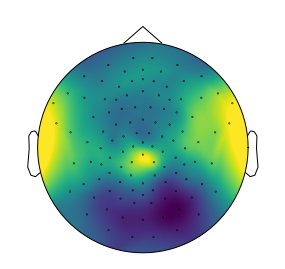

In [10]:
# Theta Alpha Ratio (TAR) topography
plot_param_topo(tars, raw, 'Ratio-TAR', SAVE_FIG)

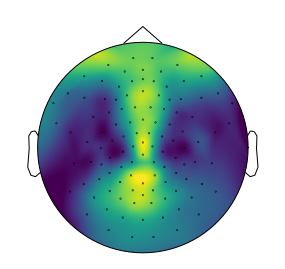

In [11]:
# Theta Beta Ratio (TBR) topography
plot_param_topo(tbrs, raw, 'Ratio-TBR', SAVE_FIG)

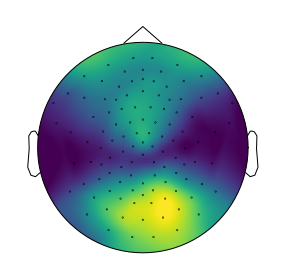

In [12]:
# Alpha Beta Ratio (ABR) topograpy
plot_param_topo(abrs, raw, 'Ratio-ABR', SAVE_FIG)

### Plot Spectral Feature Topographies

We can also plot topographies of spectral features of interest.

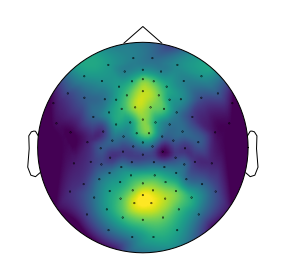

In [13]:
# Aperiodic exponent topography
plot_param_topo(exps, raw, 'Spec-AP-Exp', SAVE_FIG)

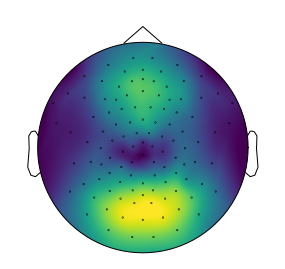

In [14]:
# Offset topography
plot_param_topo(offs, raw, 'Spec-AP-Offset', SAVE_FIG)

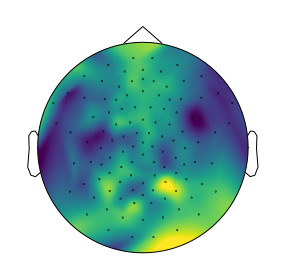

In [15]:
# Theta Power topography
plot_param_topo(theta_pw, raw, 'Spec-PE-Theta-PW', SAVE_FIG)

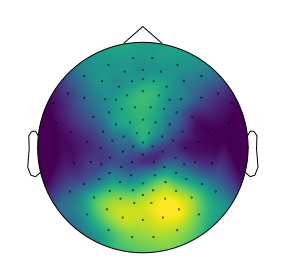

In [16]:
# Alpha Power topography
plot_param_topo(alpha_pw, raw, 'Spec-PE-Alpha-PW', SAVE_FIG)

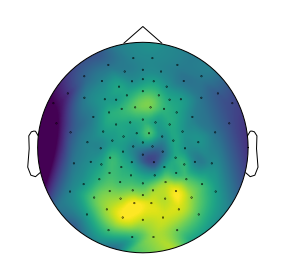

In [17]:
# Beta Power topography
plot_param_topo(beta_pw, raw, 'Spec-PE-Beta-PW', SAVE_FIG)

### Spatial Correlations

And finally, let's calculate the spatial correlations between the ratio measures and spectral parameters.

In [18]:
corr_mat = np.zeros((3, 4))
ps_mat = np.zeros((3, 4))
for ind, ratio in enumerate([tbrs, tars, abrs]):
    corr_mat[ind][0], ps_mat[ind][0] = spearmanr(ratio, theta_pw)
    corr_mat[ind][1], ps_mat[ind][1] = spearmanr(ratio, alpha_pw)
    corr_mat[ind][2], ps_mat[ind][2] = spearmanr(ratio, beta_pw)
    corr_mat[ind][3], ps_mat[ind][3] = spearmanr(ratio, exps)

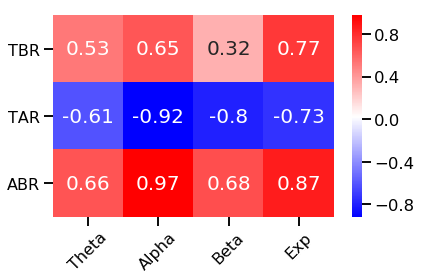

In [19]:
# Plot the correlation matrix between topographies
axes = sns.heatmap(corr_mat, cmap="bwr", yticklabels=["TBR", "TAR", "ABR"],
                   xticklabels=["Theta", "Alpha", "Beta", "Exp"],
                   annot=True, annot_kws={"size" : 20})

plt.xticks(rotation=45, fontsize=16);
plt.yticks(rotation=0, fontsize=16);
plt.tight_layout()

if SAVE_FIG: plt.savefig(fp.make_file_path(fp.eeg_topos, 'topos-correlations', 'pdf'))